# Using ML Models to Evaluate Cardiac Risk

In [1]:
# import all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,recall_score,precision_score
from xgboost import XGBClassifier
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

### Load and Explore Data

In [2]:
df = pd.read_csv("~/Downloads/archive (2)/heart_statlog_cleveland_hungary_final.csv")
print(df.head())

   age  sex  chest pain type  resting bp s  cholesterol  fasting blood sugar  \
0   40    1                2           140          289                    0   
1   49    0                3           160          180                    0   
2   37    1                2           130          283                    0   
3   48    0                4           138          214                    0   
4   54    1                3           150          195                    0   

   resting ecg  max heart rate  exercise angina  oldpeak  ST slope  target  
0            0             172                0      0.0         1       0  
1            0             156                0      1.0         2       1  
2            1              98                0      0.0         1       0  
3            0             108                1      1.5         2       1  
4            0             122                0      0.0         1       0  


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   int64  
 1   sex                  1190 non-null   int64  
 2   chest pain type      1190 non-null   int64  
 3   resting bp s         1190 non-null   int64  
 4   cholesterol          1190 non-null   int64  
 5   fasting blood sugar  1190 non-null   int64  
 6   resting ecg          1190 non-null   int64  
 7   max heart rate       1190 non-null   int64  
 8   exercise angina      1190 non-null   int64  
 9   oldpeak              1190 non-null   float64
 10  ST slope             1190 non-null   int64  
 11  target               1190 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 111.7 KB


In [4]:
df.isnull().sum() #Look for any missing values

age                    0
sex                    0
chest pain type        0
resting bp s           0
cholesterol            0
fasting blood sugar    0
resting ecg            0
max heart rate         0
exercise angina        0
oldpeak                0
ST slope               0
target                 0
dtype: int64

In [5]:
df.duplicated().sum() #Look for any missing values

272

In [6]:
# Replace 0s in numeric columns with NaN
numeric_cols = ['resting bp s', 'cholesterol', 'max heart rate']
df[numeric_cols] = df[numeric_cols].replace(0, np.nan)

# Impute missing values
df.fillna(df.median(), inplace=True)

# Cap outliers (e.g., cholesterol > 500)
df['cholesterol'] = np.where(df['cholesterol'] > 500, 500, df['cholesterol'])

# Validate categorical variables
print("Chest pain types:", df['chest pain type'].unique())
print("ST slope values:", df['ST slope'].unique())

# Check target balance
print("Target distribution:\n", df['target'].value_counts())

# Remove duplicates
df.drop_duplicates(inplace=True)

Chest pain types: [2 3 4 1]
ST slope values: [1 2 3 0]
Target distribution:
 target
1    629
0    561
Name: count, dtype: int64


In [7]:

# List of categorical columns to encode
categorical_cols = ['chest pain type', 'resting ecg', 'ST slope']

# One-hot encode these columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Check the new columns
print("Encoded columns:\n", df_encoded.columns)


Encoded columns:
 Index(['age', 'sex', 'resting bp s', 'cholesterol', 'fasting blood sugar',
       'max heart rate', 'exercise angina', 'oldpeak', 'target',
       'chest pain type_2', 'chest pain type_3', 'chest pain type_4',
       'resting ecg_1', 'resting ecg_2', 'ST slope_1', 'ST slope_2',
       'ST slope_3'],
      dtype='object')


In [8]:
df["target"].value_counts()

target
1    508
0    410
Name: count, dtype: int64

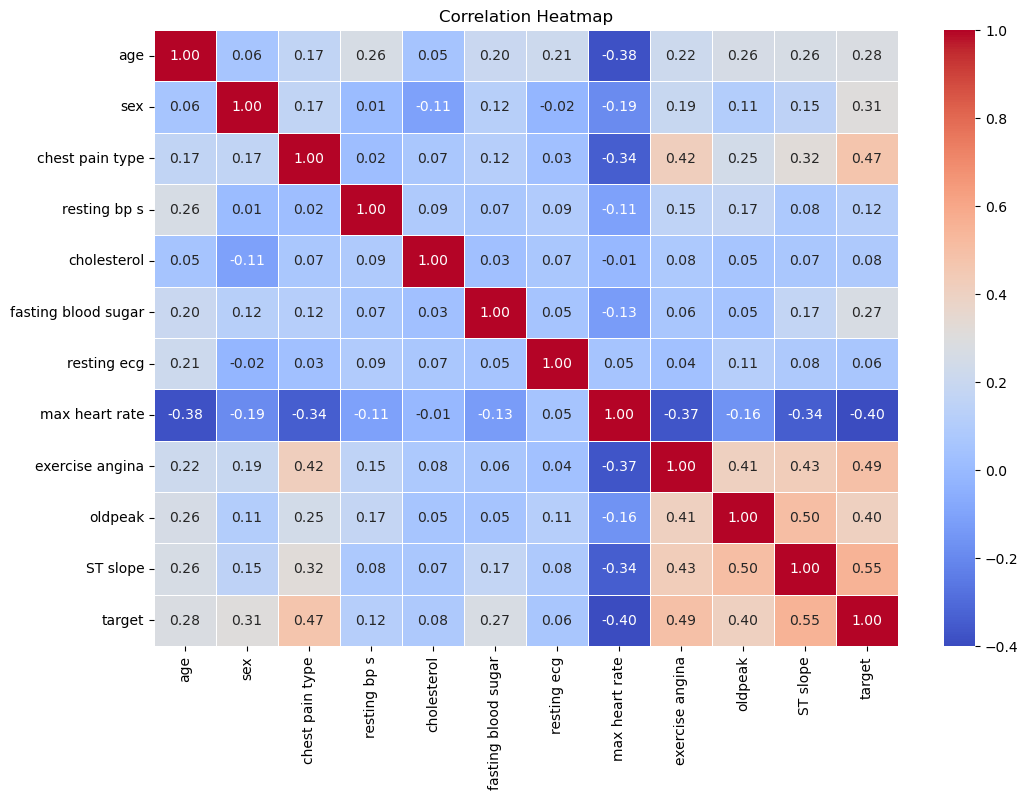

In [9]:
#Plot the correlation heatmap
plt.figure(figsize=(12, 8))
corr = df.select_dtypes(include = ["int64", "float64"]).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

### Train

In [10]:
X = df.drop('target', axis=1)
y = df['target']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [12]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [13]:
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

In [14]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [15]:
# Train and evaluate models
results = {}

for name, model in models.items():
    model.fit(X_train_res_scaled, y_train_res)
    y_pred = model.predict(X_test_scaled)
    print(f"=== {name} ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\n")

=== Logistic Regression ===
Confusion Matrix:
[[ 86  17]
 [ 11 116]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       103
           1       0.87      0.91      0.89       127

    accuracy                           0.88       230
   macro avg       0.88      0.87      0.88       230
weighted avg       0.88      0.88      0.88       230



=== Decision Tree ===
Confusion Matrix:
[[ 86  17]
 [ 26 101]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       103
           1       0.86      0.80      0.82       127

    accuracy                           0.81       230
   macro avg       0.81      0.82      0.81       230
weighted avg       0.82      0.81      0.81       230



=== AdaBoost ===
Confusion Matrix:
[[ 93  10]
 [ 16 111]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85  

/Users/venky/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:58:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## HyperParameter Tuning

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.pipeline import Pipeline
import time

In [17]:
log_reg_params = {
    'classifier__penalty': ['l1', 'l2', 'elasticnet'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10],
    'classifier__solver': ['liblinear', 'saga'],  # only these support l1/elasticnet
    'classifier__l1_ratio': [0, 0.5, 1],  # only used with elasticnet
    'classifier__max_iter': [1000, 2000]
}

# Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Gradient Boosting
gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 0.9, 1.0]
}

# XGBoost
xgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Create models
models = {
    'Logistic Regression': {
        'model': Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(random_state=42))
        ]),
        'params': log_reg_params
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': rf_params
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': gb_params
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'params': xgb_params
    }
}

# Initialize a dictionary to store results
best_models = {}
results = {}


In [18]:
# Perform hyperparameter tuning
for name, model_info in models.items():
    print(f"\n{'='*50}")
    print(f"Tuning {name}...")
    print(f"{'='*50}")
    
    start_time = time.time()
    
    # Use RandomizedSearchCV for more efficient search
    search = RandomizedSearchCV(
        model_info['model'],
        model_info['params'],
        n_iter=20,  # Number of parameter settings sampled
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    search.fit(X_train_res_scaled, y_train_res)
    
    # Calculate elapsed time
    elapsed_time = time.time() - start_time
    
    # Save best model
    best_models[name] = search.best_estimator_
    
    # Predict and evaluate
    y_pred = search.best_estimator_.predict(X_test_scaled)

    
    # Store results
    results[name] = {
        'best_params': search.best_params_,
        'best_score': search.best_score_,
        'test_accuracy': accuracy_score(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred, output_dict=True),
        'elapsed_time': elapsed_time
    }
    
    # Print results
    print(f"\nBest parameters: {search.best_params_}")
    print(f"Best cross-validation score: {search.best_score_:.4f}")
    print(f"Test accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Time elapsed: {elapsed_time:.2f} seconds")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


Tuning Logistic Regression...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/venky/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/venky/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/venky/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/venky/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/venky/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.w


Best parameters: {'classifier__solver': 'liblinear', 'classifier__penalty': 'l1', 'classifier__max_iter': 2000, 'classifier__l1_ratio': 0, 'classifier__C': 0.1}
Best cross-validation score: 0.8517
Test accuracy: 0.8739
Time elapsed: 1.42 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.86       103
           1       0.87      0.91      0.89       127

    accuracy                           0.87       230
   macro avg       0.87      0.87      0.87       230
weighted avg       0.87      0.87      0.87       230


Tuning Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Best cross-validation score: 0.8648
Test accuracy: 0.8957
Time elapsed: 2.15 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.

/Users/venky/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:58:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/venky/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:58:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/venky/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:58:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/venky/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:58:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/v


Best parameters: {'subsample': 0.9, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.9}
Best cross-validation score: 0.8714
Test accuracy: 0.8957
Time elapsed: 0.30 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       103
           1       0.91      0.91      0.91       127

    accuracy                           0.90       230
   macro avg       0.89      0.89      0.89       230
weighted avg       0.90      0.90      0.90       230



/Users/venky/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:58:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/venky/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:58:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/venky/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:58:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/venky/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:58:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/v

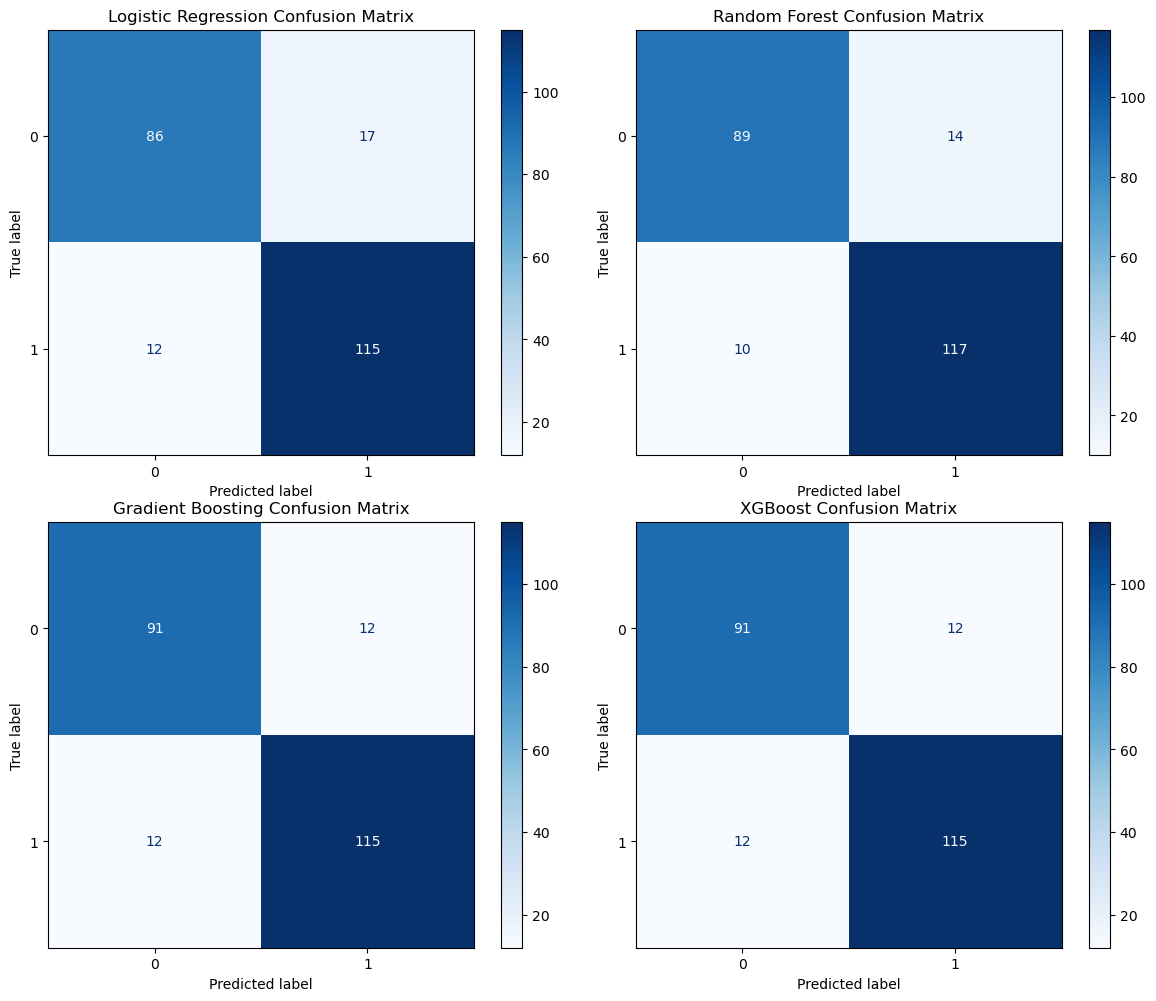

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot confusion matrix for each best model
for i, (name, model) in enumerate(best_models.items()):
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[i], cmap='Blues', values_format='d')
    axes[i].set_title(f'{name} Confusion Matrix')

plt.tight_layout()
plt.show()


In [20]:
from sklearn.metrics import confusion_matrix

# Print confusion matrices for each model
for name, model in best_models.items():
    print(f"\n{'='*50}")
    print(f"Confusion Matrix for {name}")
    print(f"{'='*50}")
    
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    print(cm)



Confusion Matrix for Logistic Regression
[[ 86  17]
 [ 12 115]]

Confusion Matrix for Random Forest
[[ 89  14]
 [ 10 117]]

Confusion Matrix for Gradient Boosting
[[ 91  12]
 [ 12 115]]

Confusion Matrix for XGBoost
[[ 91  12]
 [ 12 115]]


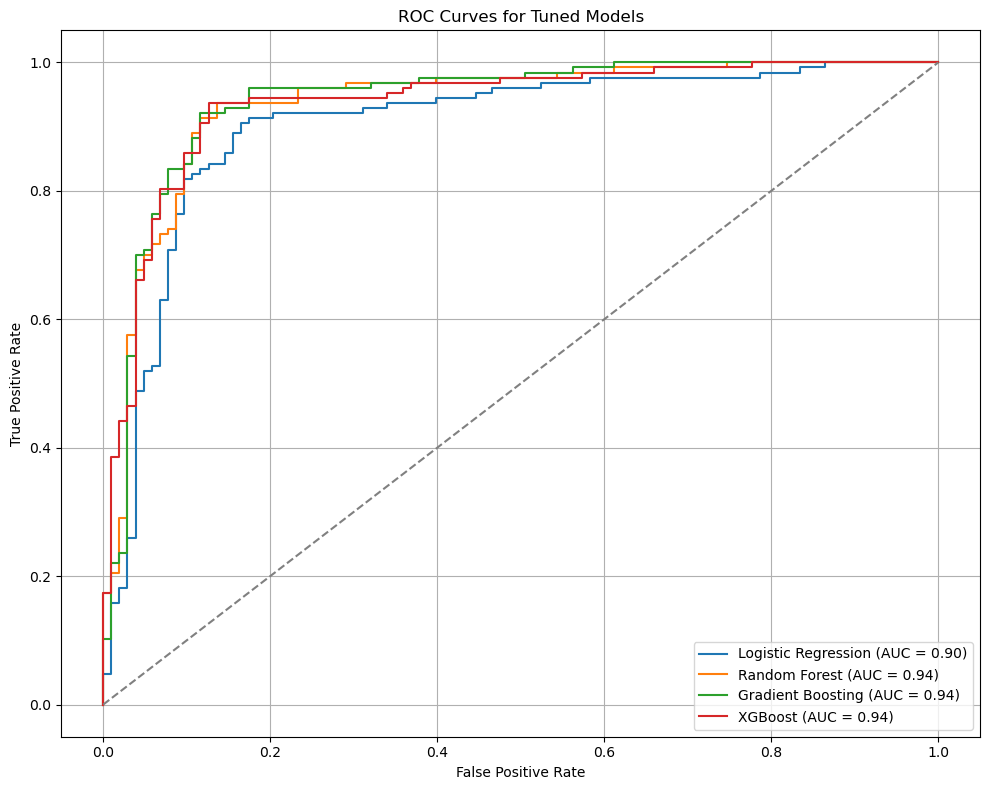


ROC AUC Scores for Tuned Models
Logistic Regression: AUC = 0.9028
Random Forest: AUC = 0.9357
Gradient Boosting: AUC = 0.9398
XGBoost: AUC = 0.9359


In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Initialize plot
plt.figure(figsize=(10, 8))

# Plot ROC curve for each model
for name, model in best_models.items():
    # Get predicted probabilities for class 1
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Format plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Tuned Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

from sklearn.metrics import roc_auc_score

print("\n" + "="*50)
print("ROC AUC Scores for Tuned Models")
print("="*50)

for name, model in best_models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
        print(f"{name}: AUC = {roc_auc:.4f}")
    else:
        print(f"{name}: This model does not support predict_proba().")
